# nuScenes devkit tutorial

Welcome to the nuScenes tutorial.

This demo assumes the database itself is available at `/data/sets/nuscenes`, and loads a mini version of the full dataset.

In [1]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='/home/nbuckman/data/sets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.5 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


## A Gentle Introduction to nuScenes

In this part of the tutorial, let us go through a top-down introduction of our database. This section is an elaboration of `schema.md`. Our dataset comprises of elemental building blocks that are the following:

1. `scene` - 20 second snippet of a car's journey.
2. `sample` - An annotated snapshot of a scene at a particular timestamp.
3. `sample_data` - Data collected from a particular sensor.
4. `sample_annotation` - An annotated instance of an object within our interest.
5. `instance` - Enumeration of all object instance we observed.
6. `category` - Taxonomy of object categories (e.g. vehicle, human). 
7. `attribute` - Property of an instance that can change while the category remains the same.
8. `visibility` - Fraction of pixels visible in all the images collected from 6 different cameras.. 
9. `sensor` - A specific sensor type.
10. `calibrated sensor` - Definition of a particular sensor as calibrated on a particular vehicle.
11. `ego_pose` - Ego vehicle poses at a particular timestamp.
12. `log` - Log information from which the data was extracted.
13. `map` - Map data that is stored as binary semantic masks from a top-down view.

### 1. `scene`

nuScenes is a large scale database that features annotated samples across ***1000 scenes*** of approximately 20 seconds each. Let's take a look at the scenes that we have in the loaded database.

In [2]:
nusc.list_scenes()

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

Let's look at a scene metadata

In [3]:
my_scene = nusc.scene[0]
my_scene

{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

### 2. Computing the Curvature

In scenes, we annotate our data every half a second (2 Hz).

We define `sample` as an ***annotated keyframe of a scene at a given timestamp***. A keyframe is a frame where the time-stamps of data from all the sensors should be very close to the time-stamp of the sample it points to.

Now, let us look at the first annotated sample in this scene.

In [21]:
import numpy as np
def compute_curvature_from_array(pose_array):
    '''Computes the curvature k from a 2xN array of ego poses.  Returns a 1xN array of curvature at each pt'''
    dx = np.gradient(pose_array[0,:])
    dy = np.gradient(pose_array[1,:])
    dydx = dy/dx
    dy2dx2 = np.gradient(dydx)/dx
    curvature = np.abs(dy2dx2/((1 + dydx**2)**(3.0/2.0)))
    return curvature

In [22]:
def get_ego_positions_from_scene(scene):
    '''Returns a 2xN array of the positions of the TOP LIDAR'''
    n_samples = scene['nbr_samples']

    pose_array = np.zeros(shape=(2, n_samples))
    i_sample = 0

    current_sample_token = scene['first_sample_token']
    current_sample = nusc.get('sample',current_sample_token)
    ego_pose_token = nusc.get('sample_data',current_sample['data']['LIDAR_TOP'])['ego_pose_token']
    ego_pose = nusc.get('ego_pose',ego_pose_token)
    pose_array[0,i_sample] = ego_pose['translation'][0]
    pose_array[1,i_sample] = ego_pose['translation'][1]

    while current_sample['next'] != '':
        i_sample += 1
        current_sample_token = current_sample['next']
        current_sample = nusc.get('sample',current_sample_token)
        ego_pose_token = nusc.get('sample_data',current_sample['data']['LIDAR_TOP'])['ego_pose_token']
        ego_pose = nusc.get('ego_pose',ego_pose_token)
        pose_array[0,i_sample] = ego_pose['translation'][0]
        pose_array[1,i_sample] = ego_pose['translation'][1]
        
    return pose_array

### Plotting Trajectories w/ Curvature

array([[1321.39076765, 1321.39024064, 1321.38998653, 1321.38988427,
        1321.38973975, 1321.38970345, 1321.3895745 , 1321.38949735,
        1321.38954603, 1321.3900927 , 1321.33197071, 1321.33090986,
        1321.33017283, 1321.32986809, 1321.19659846, 1320.48894213,
        1320.48948941, 1320.48963854, 1320.48978537, 1320.48995767,
        1320.48996372, 1320.48994033, 1320.48993447, 1320.48983099,
        1320.48998653, 1320.49002886],
       [ 903.75477114,  903.75496531,  903.75526138,  903.7555923 ,
         903.75583985,  903.75611046,  903.75627944,  903.75644735,
         903.75666638,  903.75718338,  903.72444197,  903.72645338,
         903.72828772,  903.73180248,  903.65171358,  903.28451879,
         903.28479185,  903.28487545,  903.28495594,  903.28504663,
         903.28505807,  903.2850545 ,  903.2850581 ,  903.2850151 ,
         903.28509268,  903.28511655]])

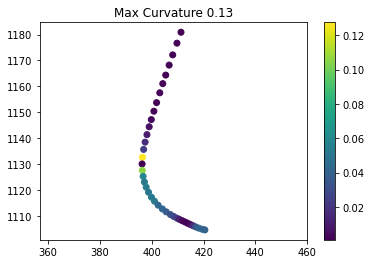

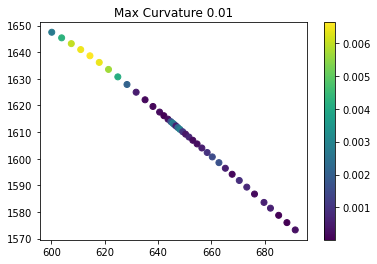

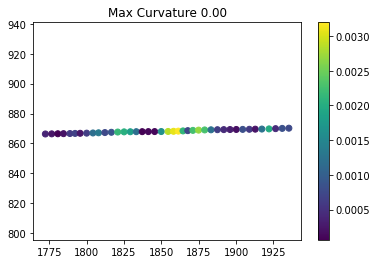

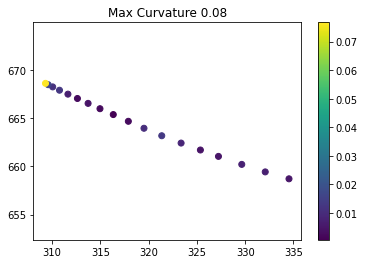

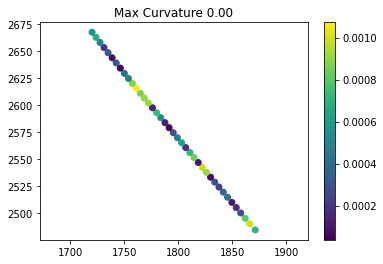

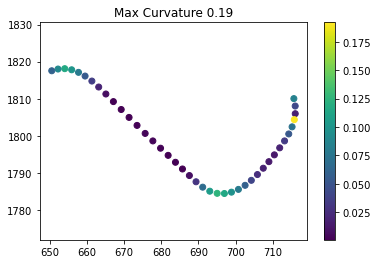

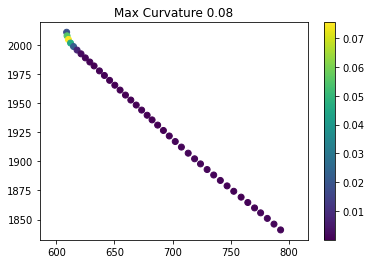

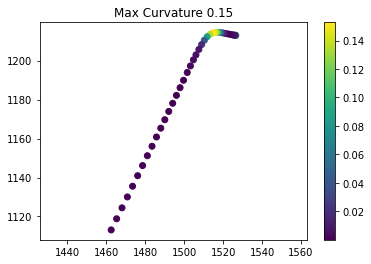

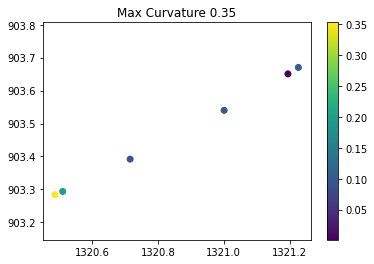

In [37]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

for scene in nusc.scene:
    pose_array = get_ego_positions_from_scene(scene)
    curvature = compute_curvature_from_array(pose_array)
    pose_array = pose_array[:,curvature<.5]
    curvature = curvature[curvature<.5]
    if len(curvature) == 0:
        continue
    max_curv, min_curv = np.max(curvature), np.min(curvature)
    plt.title('Max Curvature %.02f'%max_curv)
    plt.scatter(pose_array[0,:], pose_array[1,:],c=curvature)
    ax = plt.gca()
    ax.axis('equal')
    
    plt.colorbar()
    plt.show()    